In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import numpy as np
from skimage import feature, exposure
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import json
import matplotlib.pyplot as plt
import time


# Sample Data Preprocessing


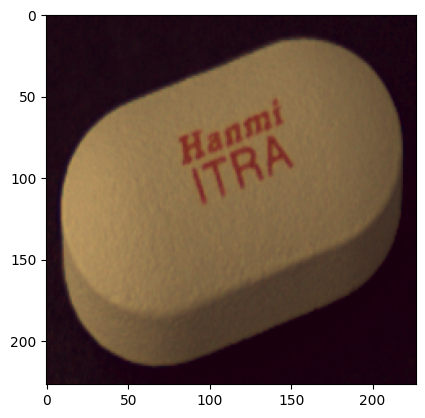

In [2]:
# 이미지를 로드합니다.
image_file_name = "file name"
pill_image = cv2.imread('image directory'+ image_file_name + '.png', cv2.IMREAD_COLOR)
# 이미지가 성공적으로 불러와졌는지 확인
if pill_image is None:
    raise ValueError(f"이미지를 불러오는 데 실패했습니다.")

# Replace with the path to yresized_imageour JSON file
json_file_path = "Label directory" + image_file_name + ".json"

# image = cv2.imread(pill_image)


# if image is None:
#     print("못불러옴")  # 이미지를 로드하지 못한 경우 건너뜁니다.

# 라벨 데이터를 로드합니다.
with open(json_file_path, 'r') as label_file:
    label_data = json.load(label_file)

# 라벨 데이터에서 분류 라벨을 추출합니다. (예: 'Normal' 또는 'Abnormal')
label = label_data['images'][0]['drug_N']


#===================경게 상자 좌표 추출 작업===================#
# 라벨링 데이터에서 경계 상자 좌표 추출
bbox = label_data['annotations'][0]['bbox']
width, length, w, h = bbox

# 이미지에서 알약 부분 잘라내기
pill_cropped = pill_image[length:length+h, width:width+w]

# 잘라낸 이미지의 크기를 확인하고, 필요한 경우 크기를 조정합니다.
pill_resized = cv2.resize(pill_cropped, (227, 227))

# 잘라낸 알약 이미지를 시각화합니다.
plt.imshow(cv2.cvtColor(pill_resized, cv2.COLOR_BGR2RGB))
plt.show()

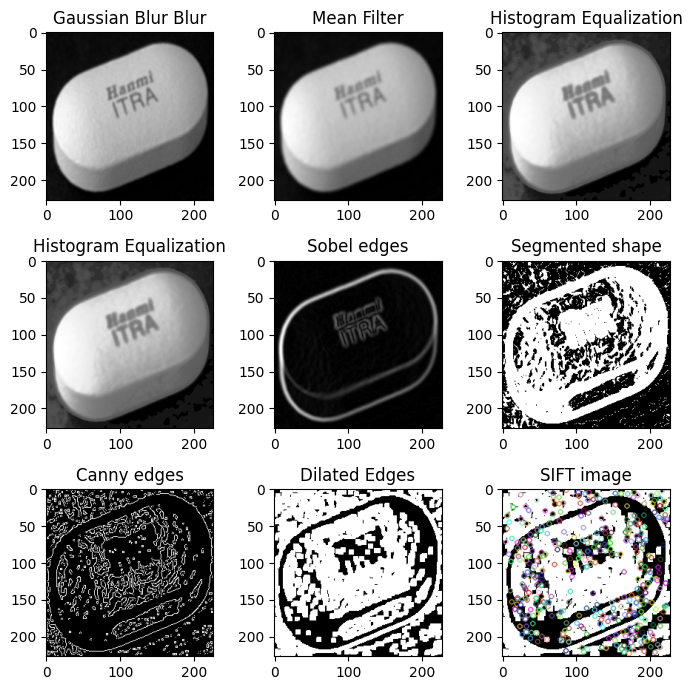

In [3]:
import os
import cv2
import json
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from matplotlib import pyplot as plt

import cv2
import numpy as np
import tensorflow as tf


# 이미지를 그레이스케일로 변환
gray = cv2.cvtColor(pill_resized, cv2.COLOR_BGR2GRAY)

# 가우시안 필터를 적용하여 블러 처리
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# 평균 필터 적용
mean_filtered = cv2.blur(blurred, (5, 5))

# 히스토그램 평활화
equalized = cv2.equalizeHist(mean_filtered)

# Sobel 필터를 사용한 형태 감지
sobelx = cv2.Sobel(mean_filtered, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(mean_filtered, cv2.CV_64F, 0, 1, ksize=5)
sobel = cv2.magnitude(sobelx, sobely)
# 임계값 적용하여 이진 이미지 생성
_, thresholded = cv2.threshold(sobel, 50, 255, cv2.THRESH_BINARY)

# Canny 에지 검출기 사용
canny_edges = cv2.Canny(np.uint8(thresholded), 100, 200)
# Dilution 작업
dilated = cv2.dilate(canny_edges, np.ones((5,5), np.uint8), iterations=1)

# SIFT 및 MLBP (예시로 SIFT만 구현, MLBP는 OpenCV에서 직접적으로 지원하지 않음)
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(dilated, None)
# 결과 이미지 반환 (SIFT 키포인트로 표시된 이미지를 반환합니다)
result_image = cv2.drawKeypoints(dilated, keypoints, None)

# OpenCV로 이미지를 BGR에서 RGB로 변환
processed_test_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

# 결과 시각화
plt.figure(figsize=(7, 7))
plt.subplot(331), plt.imshow(blurred, cmap='gray'), plt.title('Gaussian Blur Blur')
plt.subplot(332), plt.imshow(mean_filtered, cmap='gray'), plt.title('Mean Filter')
plt.subplot(333), plt.imshow(equalized, cmap='gray'), plt.title('Histogram Equalization')
plt.subplot(334), plt.imshow(equalized, cmap='gray'), plt.title('Histogram Equalization')
plt.subplot(335), plt.imshow(sobel, cmap='gray'), plt.title('Sobel edges')
plt.subplot(336), plt.imshow(thresholded, cmap='gray'), plt.title('Segmented shape')
plt.subplot(337), plt.imshow(canny_edges, cmap='gray'), plt.title('Canny edges')
plt.subplot(338), plt.imshow(dilated, cmap='gray'), plt.title('Dilated Edges')
plt.subplot(339), plt.imshow(result_image, cmap='gray'), plt.title('SIFT image')

plt.tight_layout()
plt.show()  

In [5]:
processed_test_image_rgb.shape

(227, 227, 3)

# Full data preprocessing

In [6]:
import os
import cv2
import json
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical

# 이미지와 라벨링 데이터의 경로를 지정합니다.
image_data_folder = 'image directory'
label_data_folder = 'Label directory'

# 학습 및 테스트 데이터를 저장할 리스트를 생성합니다.
X = []  # 이미지 데이터
y = []  # 라벨 데이터
count = 0
# 이미지 폴더에서 파일 이름을 반복하여 데이터를 로드합니다.
for image_code_name in os.listdir(image_data_folder):
    count += (1/8)*100
    # 이미지 파일의 전체 경로
    image_file_path = os.path.join(image_data_folder, image_code_name)
    label_file_path= os.path.join(label_data_folder, image_code_name)
    # print("ds: ", os.listdir(image_file_path))
    # print(os.listdir(label_file_path))
    print("===================", str(count) + "% 완료 ===================")
    for image in os.listdir(image_file_path):
        # 라벨 파일의 전체 image_label_path
        image_path = os.path.join(image_file_path,image)
        label_path = os.path.join(label_file_path, image[:-4]+'.json')
        
        # 이미지를 로드합니다. 
        image = cv2.imread(image_path)
        if image is None:
            print("못불러옴")  # 이미지를 로드하지 못한 경우 건너뜁니다.
        
        # 라벨 데이터를 로드합니다.
        with open(label_path, 'r') as label_file:
            label_data = json.load(label_file)
        
        # 라벨 데이터에서 분류 라벨을 추출합니다. (예: 'Normal' 또는 'Abnormal')
        label = label_data['images'][0]['drug_N']


        #===================경게 상자 좌표 추출 작업===================#
        # 라벨링 데이터에서 경계 상자 좌표 추출
        bbox = label_data['annotations'][0]['bbox']
        width, length, w, h = bbox

        # 이미지에서 알약 부분 잘라내기
        pill_cropped = image[length:length+h, width:width+w]

        # 잘라낸 이미지의 크기를 확인하고, 필요한 경우 크기를 조정합니다.
        pill_resized = cv2.resize(pill_cropped, (227, 227))
        #============================================================#

        #===================Data preprocessing===================#
        
        # 이미지를 그레이스케일로 변환
        gray = cv2.cvtColor(pill_resized, cv2.COLOR_BGR2GRAY)

        # 가우시안 필터를 적용하여 블러 처리
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        # 평균 필터 적용
        mean_filtered = cv2.blur(blurred, (5, 5))

        # 히스토그램 평활화
        equalized = cv2.equalizeHist(mean_filtered)

        # Sobel 필터를 사용한 형태 감지
        sobelx = cv2.Sobel(mean_filtered, cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(mean_filtered, cv2.CV_64F, 0, 1, ksize=5)
        sobel = cv2.magnitude(sobelx, sobely)
        # 임계값 적용하여 이진 이미지 생성
        _, thresholded = cv2.threshold(sobel, 50, 255, cv2.THRESH_BINARY)

        # Canny 에지 검출기 사용
        canny_edges = cv2.Canny(np.uint8(thresholded), 100, 200)
        # Dilution 작업
        dilated = cv2.dilate(canny_edges, np.ones((5,5), np.uint8), iterations=1)

        # SIFT 및 MLBP (예시로 SIFT만 구현, MLBP는 OpenCV에서 직접적으로 지원하지 않음)
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(dilated, None)
        # 결과 이미지 반환 (SIFT 키포인트로 표시된 이미지를 반환합니다)
        result_image = cv2.drawKeypoints(dilated, keypoints, None)

        # OpenCV로 이미지를 BGR에서 RGB로 변환
        processed_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

        # 이미지와 라벨을 리스트에 추가합니다.
        X.append(processed_image_rgb)  #RGB 차원의 data
        y.append(label)


# ss리스트를 numpy 배열로 변환합니다.
X = np.array(X)
y = np.array(y)

=================== 12.5% 완료 ===================
=================== 25.0% 완료 ===================
=================== 37.5% 완료 ===================
=================== 50.0% 완료 ===================
=================== 62.5% 완료 ===================
=================== 75.0% 완료 ===================
=================== 87.5% 완료 ===================
=================== 100.0% 완료 ===================


# Model Definition

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# CNN 모델 정의
def build_cnn_model():
    model = models.Sequential()

    # 첫 번째 합성곱 계층과 풀링 계층 추가
    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(227, 227, 3)))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # 추가 합성곱 계층과 풀링 계층 추가
    model.add(layers.Conv2D(256, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # 더 많은 합성곱 계층 추가
    model.add(layers.Conv2D(384, (3, 3), activation='relu'))
    model.add(layers.Conv2D(384, (3, 3), activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # 완전 연결 계층 추가
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))

    # 마지막 분류 계층은 제외 (훈련 후 k-NN을 사용할 것이기 때문)
    return model

# 데이터를 훈련과 테스트 세트로 분리    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
# 데이터 전처리: 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))

X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

# CNN 모델 생성
num_classes = 7  # 알약 유형의 클래스 수
cnn_model = build_cnn_model()

# 모델 컴파일
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# 특징 벡터 생성을 위한 모델 구조 변경
# CNN을 통한 특징 추출
feature_extractor = models.Model(
    inputs=cnn_model.input,
    outputs=cnn_model.get_layer(index=-3).output
)



X_train_features = feature_extractor.predict(X_train_scaled)
X_test_features = feature_extractor.predict(X_test_scaled)

# k-NN 분류기 생성 및 훈련
# CNN 시작 시간
start_knn = time.time()
k = 15  # k-NN에서 사용할 이웃의 수
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train_features, y_train)
start_knn = time.time()


# k-NN을 사용한 분류
y_pred_train = knn_classifier.predict(X_train_features)
# k-NN을 사용한 분류
y_pred_test = knn_classifier.predict(X_test_features)

# 분류 결과의 정확도 평가
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f'CNN + k-NN classifier train accuracy: {train_accuracy * 100:.2f}%')
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'CNN + k-NN classifier test accuracy: {test_accuracy * 100:.2f}%')

52/52 [==============================] - 4s 72ms/step
CNN + k-NN classifier train accuracy: 95.72%
CNN + k-NN classifier test accuracy: 94.15%


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras import layers, models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# EfficientNet 모델을 사용한 특징 추출 모델 정의
def build_efficientnet_model():
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(227, 227, 3))
    base_model.trainable = False  # 기본 모델의 가중치는 훈련 중에 업데이트되지 않도록 설정

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # 풀링 계층 추가
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        # 마지막 분류 계층은 제외 (훈련 후 k-NN을 사용할 것이기 때문에)
    ])
    return model

# EfficientNet 모델 생성
efficientnet_model = build_efficientnet_model()

# 특징 벡터 생성을 위한 모델 구조 변경
# EfficientNet을 통한 특징 추출
feature_extractor = models.Model(
    inputs=efficientnet_model.input,
    outputs=efficientnet_model.layers[-3].output  # 마지막 Dense 계층 전의 출력을 사용
)

# k-NN 분류기 생성 및 훈련
k = 15  # k-NN에서 사용할 이웃의 수
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train_features, y_train)

# k-NN을 사용한 분류 및 정확도 평가 (이전 코드와 동일)
y_pred_train = knn_classifier.predict(X_train_features)
y_pred_test = knn_classifier.predict(X_test_features)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f'EfficientNet + k-NN classifier train accuracy: {train_accuracy * 100:.2f}%')
print(f'EfficientNet + k-NN classifier test accuracy: {test_accuracy * 100:.2f}%')

EfficientNet + k-NN classifier train accuracy: 95.72%
EfficientNet + k-NN classifier test accuracy: 94.15%


# Training and evaluation for each model
- (ResNet-50, CNN+SVM learning is implemented using GPT-4.)

### CNN+K-nn 모델 학습

In [67]:
# k-NN 분류기 생성 및 훈련
k = 5  # k-NN에서 사용할 이웃의 수
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train_features, y_train)


# k-NN을 사용한 분류
y_pred_train_cnn = knn_classifier.predict(X_train_features)
y_pred_test_cnn = knn_classifier.predict(X_test_features)


# 분류 결과의 정확도 평가
train_accuracy_knn = accuracy_score(y_train, y_pred_train)
print(f'CNN + k-NN classifier accuracy: {train_accuracy_knn * 100:.2f}%')
test_accuracy_knn = accuracy_score(y_test, y_pred_test)
print(f'CNN + k-NN classifier accuracy: {test_accuracy_knn * 100:.2f}%')

CNN + k-NN classifier accuracy: 95.72%
CNN + k-NN classifier accuracy: 94.15%


### CNN+SVM Training

In [68]:
from sklearn.svm import SVC

# SVM 분류기 생성 및 훈련
svm_classifier = SVC(probability=True, kernel='linear', C=1)
svm_classifier.fit(X_train_features, y_train)

# SVM을 사용한 분류
y_pred_svm_train = svm_classifier.predict(X_train_features)
y_pred_svm_test = svm_classifier.predict(X_test_features)



# 분류 결과의 정확도 평가
train_accuracy_svm = accuracy_score(y_train, y_pred_svm_train)
print(f'CNN + SVM classifier accuracy: {train_accuracy_svm * 100:.2f}%')
test_accuracy_svm = accuracy_score(y_test, y_pred_svm_test)
print(f'CNN + SVM classifier accuracy: {test_accuracy_svm * 100:.2f}%')

CNN + SVM classifier accuracy: 91.49%
CNN + SVM classifier accuracy: 87.15%


### ResNet-50 Training

In [69]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# ResNet-50 모델 로드 (사전 훈련된 가중치 포함)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(227, 227, 3))

# 데이터 전처리: ResNet-50에 맞게 입력 데이터 전처리
X_train_resnet = preprocess_input(X_train_scaled)
X_test_resnet = preprocess_input(X_test_scaled)

# ResNet-50을 통한 특징 추출
X_train_resnet_features = resnet50_model.predict(X_train_resnet)
X_test_resnet_features = resnet50_model.predict(X_test_resnet)

# 특징 벡터 평탄화 (훈련을 위해)
X_train_resnet_features_flat = X_train_resnet_features.reshape(X_train_resnet_features.shape[0], -1)
X_test_resnet_features_flat = X_test_resnet_features.reshape(X_test_resnet_features.shape[0], -1)

# k-NN 분류기 (ResNet-50 특징을 사용) 생성 및 훈련
knn_classifier_resnet = KNeighborsClassifier(n_neighbors=k)
knn_classifier_resnet.fit(X_train_resnet_features_flat, y_train)

# k-NN을 사용한 분류 (ResNet-50 특징을 사용)
y_pred_resnet_test = knn_classifier_resnet.predict(X_test_resnet_features_flat)
y_pred_resnet_train = knn_classifier_resnet.predict(X_train_resnet_features_flat)

# 분류 결과의 정확도 평가
accuracy_resnet_train = accuracy_score(y_train, y_pred_resnet_train)
print(f'ResNet-50 + k-NN classifier train set accuracy: {accuracy_resnet_train * 100:.2f}%')
accuracy_resnet_test = accuracy_score(y_test, y_pred_resnet_test)
print(f'ResNet-50 + k-NN classifier test set accuracy: {accuracy_resnet_test * 100:.2f}%')

52/52 [==============================] - 50s 932ms/step
ResNet-50 + k-NN classifier train set accuracy: 99.74%
ResNet-50 + k-NN classifier test set accuracy: 99.39%


# Compare models

### 1. mAP comparison by model

In [70]:
def calculate_precision_at_k(y_true, y_pred, k=7):
    """상위 k개 예측에 대한 정밀도 계산"""
    relevant_items = 0
    for i in range(k):
        if y_pred[i] in y_true:
            relevant_items += 1
    return relevant_items / k

def calculate_average_precision(y_true, y_pred):
    """각 k에 대한 정밀도의 평균 계산으로 AP 계산"""
    precisions = [calculate_precision_at_k(y_true, y_pred, k+1) for k in range(len(y_pred))]
    # 실제로 관련 있는 항목만 고려하여 평균을 계산합니다.
    if sum(precisions) == 0:
        return 0
    return sum(precisions) / len(y_true)

def calculate_map(y_trues, y_preds):
    """모든 객체에 대한 AP의 평균을 계산하여 mAP 계산"""
    average_precisions = [calculate_average_precision(y_trues[i], y_preds[i]) for i in range(len(y_trues))]
    return sum(average_precisions) / len(average_precisions)

# 예제 데이터
y_trues = [[1, 2, 3], [1, 2, 4], [1, 2]]  # 각 객체에 대한 실제 관련 항목
y_preds = [[1, 2, 4], [1, 2, 3], [1, 3]]  # 모델의 예측 순위

# mAP 계산
ResNet50_map_score = calculate_map(y_test, y_pred_resnet_test)
print(f"mAP: {ResNet50_map_score}")
SVM_map_score = calculate_map(y_test, y_pred_svm_test)
print(f"mAP: {SVM_map_score}")
CNN_map_score = calculate_map(y_test, y_pred_test_cnn)
print(f"mAP: {CNN_map_score}")


mAP: 0.9993950648164261
mAP: 0.9843561495852916
mAP: 0.9963155595673107


In [71]:
print(np.unique(y_test, return_counts=True))

(array(['K-001027', 'K-001029', 'K-001451', 'K-002058', 'K-004378',
       'K-009460', 'K-010733', 'K-016230'], dtype='<U8'), array([268, 263, 261,  37, 268, 259,  49, 237], dtype=int64))


### 2. Precision-Recall Curve comparison for each model


              precision    recall  f1-score   support

    K-001027       0.97      0.97      0.97       268
    K-001029       0.97      0.97      0.97       263
    K-001451       0.97      1.00      0.98       261
    K-002058       0.87      0.89      0.88        37
    K-004378       0.96      0.99      0.98       268
    K-009460       0.97      0.98      0.97       259
    K-010733       1.00      0.63      0.78        49
    K-016230       0.97      0.97      0.97       237

    accuracy                           0.97      1642
   macro avg       0.96      0.93      0.94      1642
weighted avg       0.97      0.97      0.97      1642



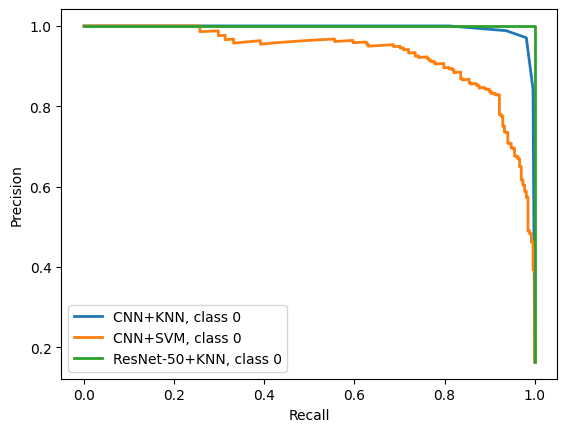

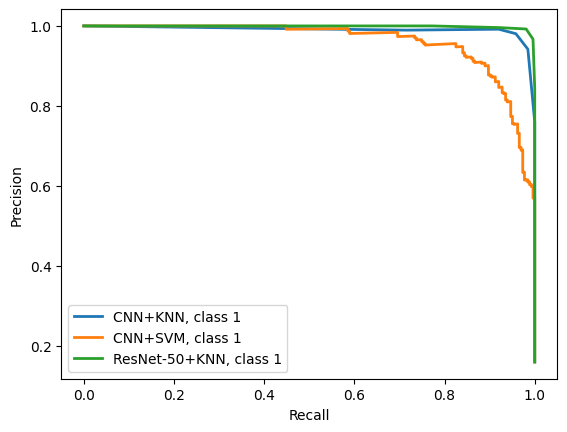

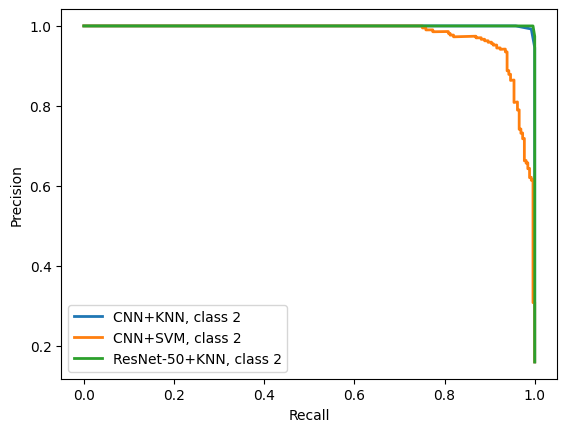

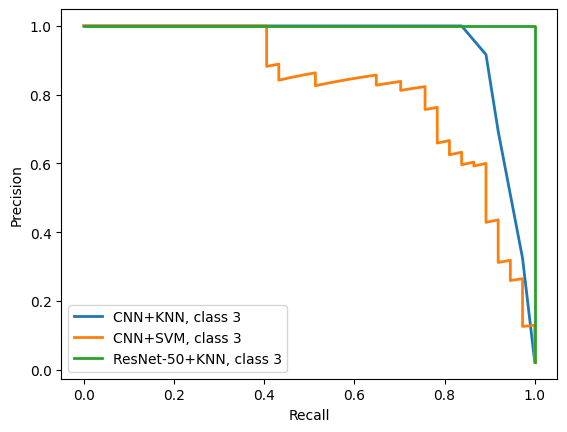

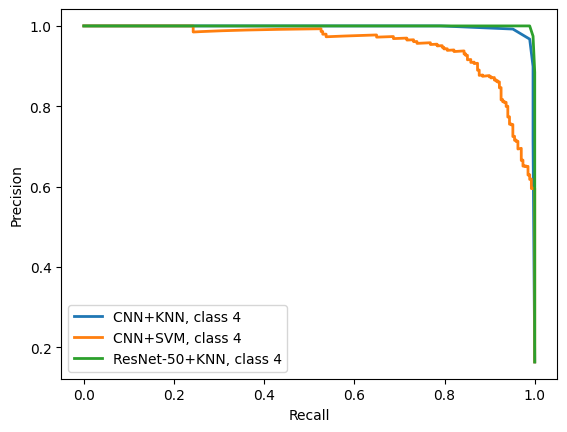

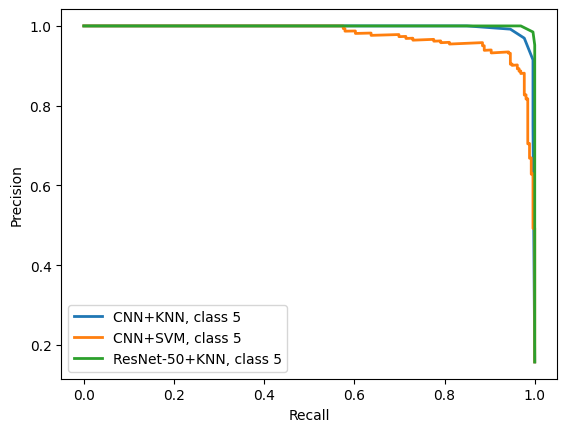

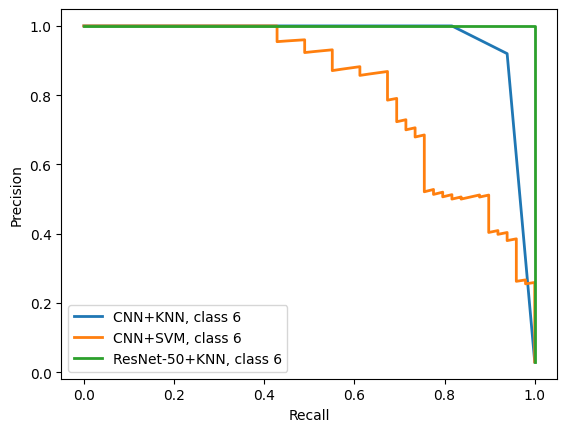

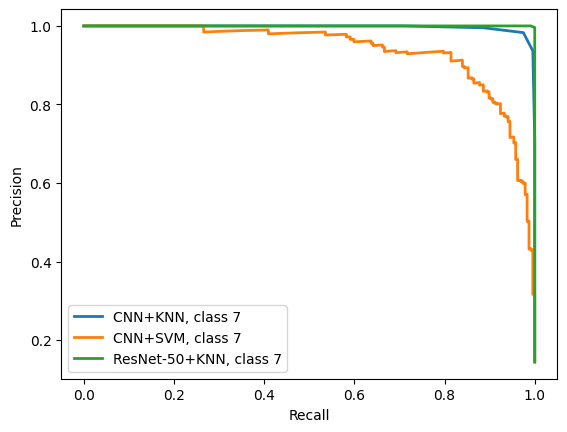

In [72]:
from sklearn.metrics import classification_report
from sklearn.preprocessing  import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

report = classification_report(y_test, y_pred_test_cnn, target_names=['K-001027', 'K-001029', 'K-001451', 
                                                                      'K-002058', 'K-004378','K-009460', 
                                                                      'K-010733', 'K-016230'])
print(report)

# y_test를 원-핫 인코딩 형태로 변환
# classes 파라미터에는 모든 가능한 클래스의 리스트를 전달합니다.
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]
y_score_cnn     = knn_classifier.predict_proba(X_test_features)
y_score_svm     = svm_classifier.predict_proba(X_test_features)
y_score_resnet  = knn_classifier_resnet.predict_proba(X_test_resnet_features_flat)


# 각 클래스에 대한 정밀도와 재현율 계산
for i in range(8):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_score_cnn[:, i])
    plt.plot(recall, precision, lw=2, label=f'CNN+KNN, class {i}')
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_score_svm[:, i])
    plt.plot(recall, precision, lw=2, label=f'CNN+SVM, class {i}')
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_score_resnet[:, i])
    plt.plot(recall, precision, lw=2, label=f'ResNet-50+KNN, class {i}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="best")
    plt.show()

### 3. Roc curve comparison for each model

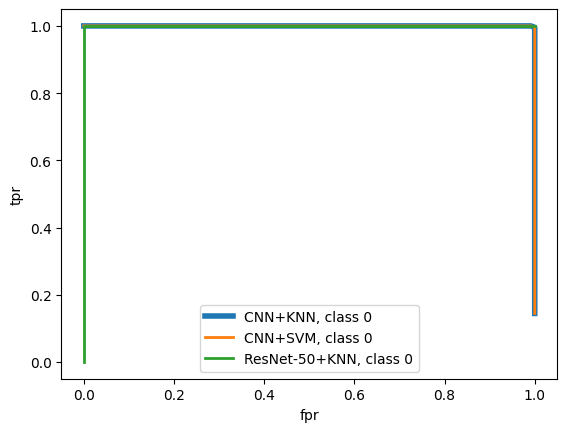

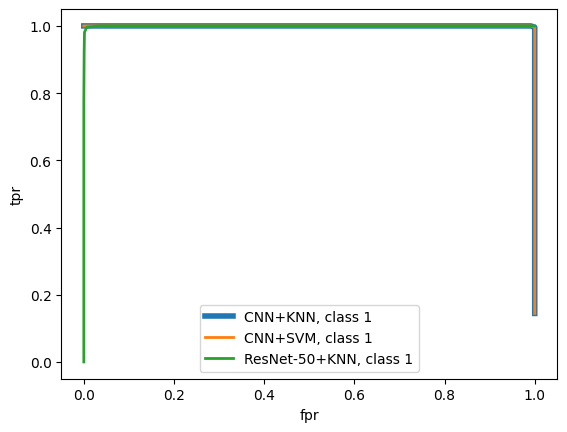

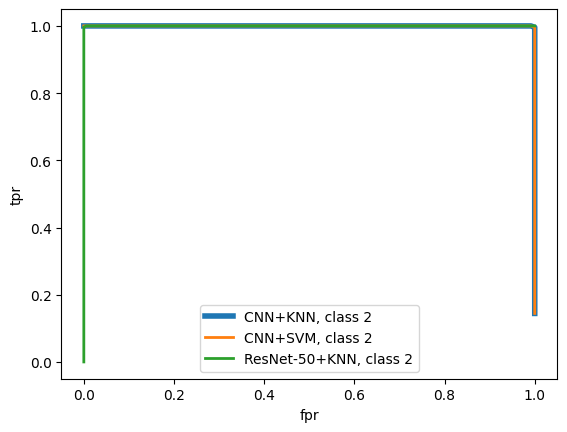

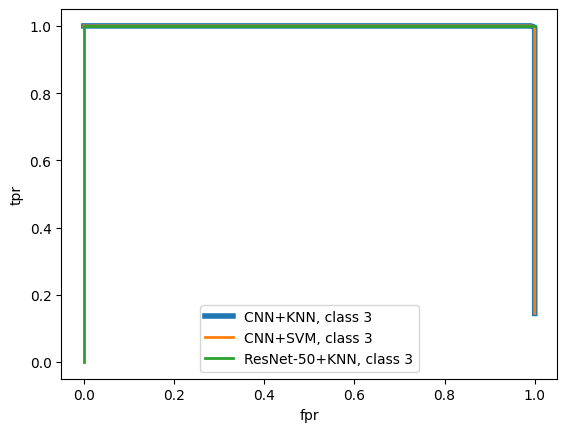

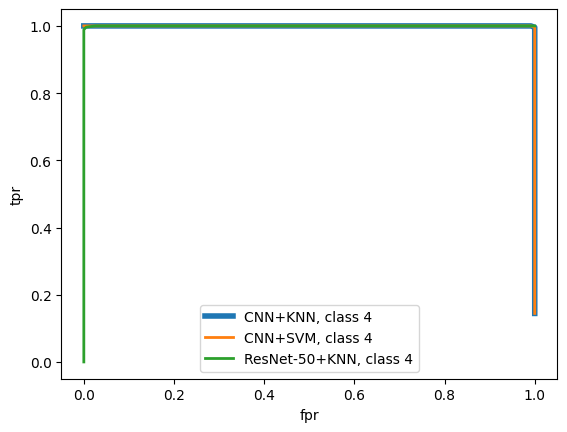

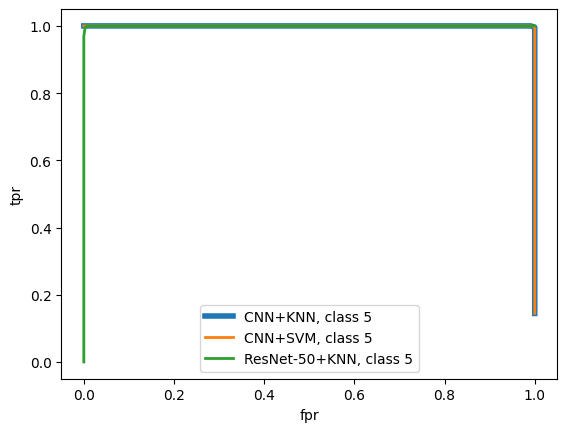

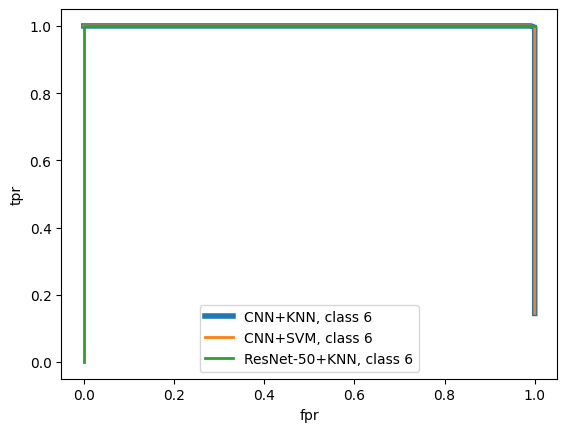

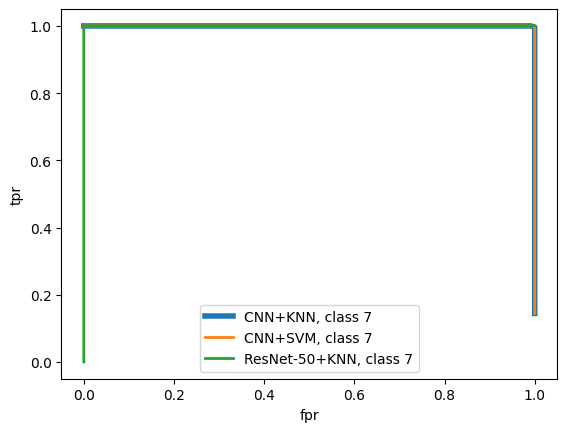

In [73]:
from sklearn.metrics import roc_curve
# 각 클래스에 대한 정밀도와 재현율 계산
for i in range(8):
    tpr, fpr, _ = roc_curve(y_test_binarized[:, i], y_score_cnn[:, i])
    plt.plot(recall, precision, lw=4, label=f'CNN+KNN, class {i}')
    tpr, fpr, _ = roc_curve(y_test_binarized[:, i], y_score_svm[:, i])
    plt.plot(recall, precision, lw=2, label=f'CNN+SVM, class {i}')
    tpr, fpr, _ = roc_curve(y_test_binarized[:, i], y_score_resnet[:, i])
    plt.plot(tpr, fpr, lw=2, label=f'ResNet-50+KNN, class {i}')
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.legend(loc="best")
    plt.show()

In [74]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

# ResNet-50 모델 로드 (사전 훈련된 가중치 포함)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(227, 227, 3))

# 데이터 전처리: ResNet-50에 맞게 입력 데이터 전처리
X_train_resnet = preprocess_input(X_train_scaled)
X_test_resnet = preprocess_input(X_test_scaled)

# ResNet-50을 통한 특징 추출
X_train_resnet_features = resnet50_model.predict(X_train_resnet)
X_test_resnet_features = resnet50_model.predict(X_test_resnet)

# 특징 벡터 평탄화 (훈련을 위해)
X_train_resnet_features_flat = X_train_resnet_features.reshape(X_train_resnet_features.shape[0], -1)
X_test_resnet_features_flat = X_test_resnet_features.reshape(X_test_resnet_features.shape[0], -1)

# k-NN 분류기 (ResNet-50 특징을 사용) 생성 및 훈련
knn_classifier_resnet = KNeighborsClassifier(n_neighbors=k)
knn_classifier_resnet.fit(X_train_resnet_features_flat, y_train)

# k-NN을 사용한 분류 (ResNet-50 특징을 사용)
y_pred_resnet_test = knn_classifier_resnet.predict(X_test_resnet_features_flat)
y_pred_resnet_train = knn_classifier_resnet.predict(X_train_resnet_features_flat)

# 분류 결과의 정확도 평가
accuracy_resnet_train = accuracy_score(y_train, y_pred_resnet_train)
print(f'ResNet-50 + k-NN classifier train set accuracy: {accuracy_resnet_train * 100:.2f}%')
accuracy_resnet_test = accuracy_score(y_test, y_pred_resnet_test)
print(f'ResNet-50 + k-NN classifier test set accuracy: {accuracy_resnet_test * 100:.2f}%')

52/52 [==============================] - 46s 868ms/step
ResNet-50 + k-NN classifier train set accuracy: 99.48%
ResNet-50 + k-NN classifier test set accuracy: 98.54%


### 4. K-fold Cross-validation

In [75]:
from sklearn.model_selection import cross_val_score

# k-폴드 교차 검증 수행 (여기서는 k=5)
scores = cross_val_score(knn_classifier, X_train_features, y_train, cv=5)
# 교차 검증 결과 출력
print("교차 검증 점수:", scores)

교차 검증 점수: [0.95509893 0.9581112  0.94897182 0.95430312 0.94973343]


### 5. Runtime Comparison

In [76]:
# Firebase로부터 data를 받아옴
def predict_with_model(model, data):
    start_time = time.time()
    model.predict(data)  # 가정된 예측 함수
    return (time.time() - start_time) * 1000  # ms 단위로 반환

# 예제 데이터
data_example = np.random.rand(100, 224, 224, 3)  # 100개의 224x224 RGB 이미지

# 모델별 실행 시간 측정
runtime_cnn_knn = predict_with_model(cnn_knn_model, processed_test_image_rgb)
runtime_cnn_svm = predict_with_model(cnn_svm_model, processed_test_image_rgb)
runtime_resnet50 = predict_with_model(resnet50_model, processed_test_image_rgb)


NameError: name 'cnn_knn_model' is not defined

# Test

In [78]:
import time
# 주어진 이미지 (processed_image)에 대해 특징 추출 후 k-NN을 사용하여 클래스를 예측합니다.
# CNN 모델로부터 특징 추출기를 만듭니다.
# feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-3].output)

# 이미지를 모델의 입력에 맞는 크기로 조정합니다. (예: 227x227)
# 새로운 이미지를 로드합니다 (예시 경로를 'new_image_path'에 지정해야 함)
new_image = cv2.cvtColor(pill_image, cv2.COLOR_BGR2RGB) # cv2는 이미지를 BGR 형식으로 로드합니다, RGB로 변환

# 이미지를 모델의 입력 크기에 맞게 조정합니다
new_image_resized = cv2.resize(new_image, (227, 227)) # CNN 모델의 입력 크기에 맞게 조정

# 이미지를 정규화하고 차원을 추가합니다 (모델은 배치 차원을 기대합니다)
new_image_scaled = scaler.transform(new_image_resized.reshape(1, -1))
new_image_scaled = new_image_scaled.reshape((1, 227, 227, 3))

# CNN+KNN runtime start
start_time_cnnknn = time.time()
# CNN을 통해 특징을 추출합니다.
features = feature_extractor.predict(new_image_scaled)
# k-NN 분류기를 사용하여 클래스를 예측합니다.
predicted_class = knn_classifier.predict(features)
print(predicted_class)
end_cnnknn = time.time()
# CNN+KNN runtime end
#==================================================#

# CNN+SVMruntime start
start_time_svm = time.time()
# CNN을 통해 특징을 추출합니다.
features = feature_extractor.predict(new_image_scaled)
# k-NN 분류기를 사용하여 클래스를 예측합니다.
predicted_class = svm_classifier.predict(features)
print(predicted_class)
end_svm = time.time()
# CNN+SVM runtime end
#==================================================#

# ResNet-50 runtime start
start_time_resnet = time.time()
# 데이터 전처리: ResNet-50에 맞게 입력 데이터 전처리
features = preprocess_input(new_image_scaled)
# ResNet-50을 통한 특징 추출
X_train_resnet_features = resnet50_model.predict(features)
# 특징 벡터 평탄화 (훈련을 위해)
X_train_resnet_features_flat = X_train_resnet_features.reshape(X_train_resnet_features.shape[0], -1)
# k-NN을 사용한 분류 (ResNet-50 특징을 사용)
y_pred_resnet_test = knn_classifier_resnet.predict(X_train_resnet_features_flat)
print(y_pred_resnet_test)
end_resnet = time.time()
# ResNet-50 runtime end
#==================================================#

print(f"Runtime for CNN+kNN: {end_cnnknn - start_time_cnnknn:.2f} ms")
print(f"Runtime for CNN+SVM: {end_svm - runtime_cnn_svm:.2f} ms")
print(f"Runtime for ResNet-50: {end_resnet - start_time_resnet:.2f} ms")

# 잘라낸 알약 이미지를 시각화합니다.
plt.imshow(cv2.cvtColor(processed_test_image_rgb, cv2.COLOR_BGR2RGB))
plt.show()

1/1 [==============================] - 2s 2s/step
['K-001027']
1/1 [==============================] - 0s 72ms/step
['K-016230']
1/1 [==============================] - 0s 245ms/step
['K-016230']
Runtime for CNN+kNN: 1.99 ms


NameError: name 'runtime_cnn_svm' is not defined